In [6]:
import numpy as np
from PIL import Image
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing import image
from scipy.linalg import sqrtm
import os
def extract_frames_from_gif(gif_path):
    frames = []
    with Image.open(gif_path) as im:
        try:
            while True:
                frame = im.copy()
                frames.append(frame.convert('RGB'))  # 转换为RGB格式
                im.seek(im.tell() + 1)
        except EOFError:
            pass
    return frames

def get_activations(images, model):
    activations = []
    for img in images:
        img = img.resize((299, 299))  # InceptionV3的输入尺寸
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        act = model.predict(x)
        activations.append(act[0])
    activations = np.array(activations)
    return activations

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2):
    diff = mu1 - mu2
    # 计算协方差矩阵的平方根
    covmean, _ = sqrtm(sigma1.dot(sigma2), disp=False)
    # 处理数值误差导致的复数结果
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    # 计算FID
    fid = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid

# 主程序
path1 = ''
path2 = ''
files1 = os.listdir(path1)
files2 = os.listdir(path2)
re = []
for i in range(len(files1)):
    gif_path1 = path1 + files1[i]   # 第一个GIF文件路径
    gif_path2 = path2 + files2[i]   # 第二个GIF文件路径

    # 提取两个GIF的帧
    frames1 = extract_frames_from_gif(gif_path1)
    frames2 = extract_frames_from_gif(gif_path2)

    # 加载预训练的InceptionV3模型
    model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

    # 获取激活值
    act1 = get_activations(frames1, model)
    act2 = get_activations(frames2, model)

    # 计算均值和协方差
    mu1, sigma1 = np.mean(act1, axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = np.mean(act2, axis=0), np.cov(act2, rowvar=False)

    # 计算FID
    fid_value = calculate_frechet_distance(mu1, sigma1, mu2, sigma2)
    print(f'两个GIF之间的FID值为: {fid_value}')
    re.append(fid_value)
print(np.mean(re))


1/1 [==============================] - 0s 343ms/step
两个GIF之间的FID值为: 156.63969820918683


In [8]:
import numpy as np
np.mean([1,2])


1.5

In [11]:
!pip install pdf2image

ERROR: Invalid requirement: 'pdf2image,'


In [1]:
from pdf2image import convert_from_path

# Convert the PDF pages to images
pdf_path = '/Health - ECG 2024-09-14 at 00.53.pdf'
pages = convert_from_path(pdf_path, 300)

# Save the images of pages containing the ECG
for i, page in enumerate(pages):
    page.save(f'ecg_page_{i+1}.png', 'PNG')


In [20]:
import cv2
import numpy as np

# Load the ECG image
ecg_image_path = 'ecg_page_2.png'  # Adjust the page index based on the correct page number
img = cv2.imread(ecg_image_path, cv2.IMREAD_GRAYSCALE)

# Apply edge detection to highlight the ECG line
edges = cv2.Canny(img, 50, 150)

# Find contours in the image
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Initialize an empty array to store the ECG signal
ecg_signal = []

# Extract the points from the largest contour (assuming it’s the ECG signal)
if contours:
    largest_contour = max(contours, key=cv2.contourArea)
    for point in largest_contour:
        ecg_signal.append(point[0][1])  # Append the Y-coordinate of each point

# Normalize the signal (optional, depending on your use case)
ecg_signal = np.array(ecg_signal)
# ecg_signal = (ecg_signal - np.min(ecg_signal)) / (np.max(ecg_signal) - np.min(ecg_signal))


In [5]:
process_ekg(ecg_signal)

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.04761905, 0.11111111, ..., 0.29494355, 0.26775216,
        0.29100529],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [2]:
import torch
from scipy import interpolate
def process_ekg(ekg_data, target_length=2250, repetitions=16):
    processed_ekg = np.zeros((12, target_length))
    
    # 원본 데이터를 16번 반복
    repeated_data = np.tile(ekg_data, repetitions)
    
    # 반복된 데이터의 길이
    original_length = len(repeated_data)
    
    if original_length < target_length:
        # Interpolation
        x = np.linspace(0, 1, original_length)
        f = interpolate.interp1d(x, repeated_data, kind='linear')
        x_new = np.linspace(0, 1, target_length)
        processed_ekg[1] = f(x_new)
    elif original_length > target_length:
        # Resampling
        x = np.linspace(0, 1, original_length)
        x_new = np.linspace(0, 1, target_length)
        processed_ekg[1] = np.interp(x_new, x, repeated_data)
    else:
        processed_ekg[1] = repeated_data[:target_length]
    if not isinstance(processed_ekg, np.ndarray):
        processed_ekg = np.array(processed_ekg)
    
    # Z-score 정규화
    processed_ekg = (processed_ekg - np.mean(processed_ekg)) / np.std(processed_ekg)
    
    # 이미 적절한 샘플링 레이트라고 가정. 필요하다면 여기서 리샘플링
    
    return torch.from_numpy(processed_ekg).float().unsqueeze(0)  # (1, length)
   

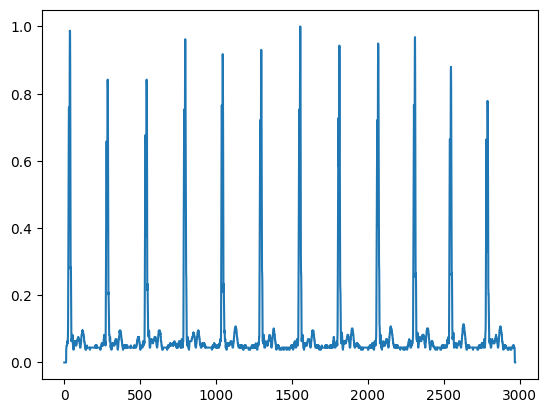

In [30]:
import matplotlib.pyplot as plt
plt.plot(signal)
plt.show()


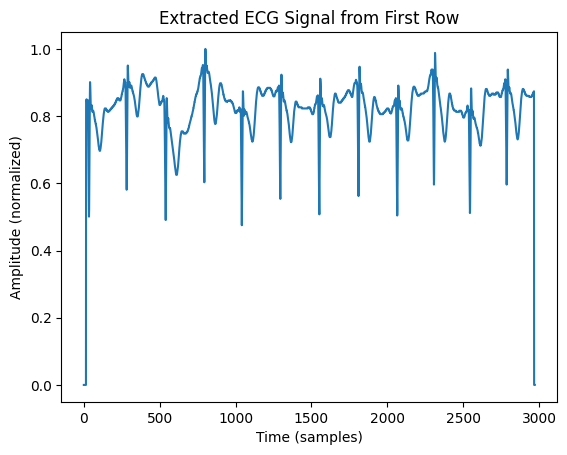

[0. 0. 0. ... 0. 0. 0.]


In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = 'ecg_page_2.png'
image = cv2.imread(image_path)

# Convert the image to RGB (OpenCV loads images in BGR by default)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Crop the image to focus on the first row of the ECG signal
# Adjust these values based on the actual position of the first row in the image
cropped_image = image_rgb[:, :]  # Modify these values if necessary

# Isolate the red color channel (assumes red is the dominant color of the ECG)
lower_red = np.array([100, 0, 0])
upper_red = np.array([255, 100, 100])

# Create a mask that captures the red lines in the cropped image
mask = cv2.inRange(cropped_image, lower_red, upper_red)

# Apply the mask to extract only the red parts of the cropped image
red_extracted = cv2.bitwise_and(cropped_image, cropped_image, mask=mask)

# Convert the red extraction to grayscale to detect the ECG signal
gray_ecg = cv2.cvtColor(red_extracted, cv2.COLOR_RGB2GRAY)

# Find the coordinates of the non-zero values, which correspond to the ECG signal
y_coords, x_coords = np.where(gray_ecg > 0)

# Create an empty array to hold the ECG signal from the first row
ecg_signal_first_row = np.zeros(gray_ecg.shape[1])

# Populate the ECG signal by averaging the y-values at each x-coordinate
for x in range(gray_ecg.shape[1]):
    y_vals = y_coords[x_coords == x]
    if len(y_vals) > 0:
        ecg_signal_first_row[x] = np.mean(y_vals)

# Normalize the ECG signal (optional)
ecg_signal_first_row = (ecg_signal_first_row - np.min(ecg_signal_first_row)) / (np.max(ecg_signal_first_row) - np.min(ecg_signal_first_row))

# Plot the extracted ECG signal from the first row
plt.plot(ecg_signal_first_row)
plt.title("Extracted ECG Signal from First Row")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude (normalized)")
plt.show()

# Output the ECG signal as an array
print(ecg_signal_first_row)


In [10]:
image.shape

(2550, 3301, 3)

In [25]:
from PIL import Image
import numpy as np

# Load the image
image_path = 'ecg_page_2.png'
image = Image.open(image_path)

# Convert image to numpy array
image_array = np.array(image)

# Extract the red channel
red_channel = image_array[:, :, 0]

# Since the background is white (255, 255, 255), we will extract only the red values
# which are significantly lower than 255 to identify the ECG line
threshold = 200
ecg_signal = np.where(red_channel < threshold, red_channel, 0)

# Display the shape to see what we've got
ecg_signal.shape


(366, 2972)

In [29]:
import cv2
import numpy as np

# 读取图像
image = cv2.imread('/ecg_page_2.png')  # 替换为你的图像文件路径

# 将图像转换为HSV颜色空间
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# 定义红色的HSV范围
# 红色在HSV颜色空间中有两个范围，需要分别处理
lower_red1 = np.array([0, 70, 50])
upper_red1 = np.array([10, 255, 255])

lower_red2 = np.array([170, 70, 50])
upper_red2 = np.array([180, 255, 255])

# 创建红色掩码
mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
mask = cv2.bitwise_or(mask1, mask2)

# 对掩码进行形态学处理，去除噪点
kernel = np.ones((3, 3), np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
mask = cv2.morphologyEx(mask, cv2.MORPH_DILATE, kernel)

# 找到红色像素的位置
red_positions = np.column_stack(np.where(mask > 0))

# 将二维的位置转换为一维信号，例如对行求和
signal = np.sum(mask, axis=0)

# 归一化信号（可选）
signal = signal / np.max(signal)

# 保存或输出一维信号
# np.savetxt('signal.txt', signal)

print("提取的一维信号：", signal)


提取的一维信号： [0. 0. 0. ... 0. 0. 0.]


In [9]:
!git clone https://github.com/piergiaj/pytorch-i3d.git

Cloning into 'pytorch-i3d'...
remote: Enumerating objects: 21, done.
remote: Total 21 (delta 0), reused 0 (delta 0), pack-reused 21 (from 1)
Receiving objects: 100% (21/21), 178.18 MiB | 31.45 MiB/s, done.
Resolving deltas: 100% (5/5), done.
Updating files: 100% (12/12), done.


In [10]:
!cd pytorch-i3d
!python setup.py install
!cd ..

python: can't open file 'setup.py': [Errno 2] No such file or directory


In [3]:
import tensorflow as tf
import numpy as np
from scipy import linalg
from tensorflow_hub import load as hub_load
from PIL import Image

# Load pre-trained I3D model from TensorFlow Hub
i3d_model = hub_load("https://tfhub.dev/deepmind/i3d-kinetics-400/1")

def load_gif(filename):
    """
    Load a GIF file and convert it into a numpy array of shape (frames, height, width, channels).
    
    Args:
        filename: Path to the GIF file.
    
    Returns:
        Numpy array with shape (frames, height, width, 3).
    """
    gif = Image.open(filename)
    frames = []
    
    try:
        while True:
            # Convert each frame to RGB and resize to (128, 128)
            frame = gif.convert("RGB").resize((128, 128))
            frames.append(np.array(frame))
            gif.seek(gif.tell() + 1)
    except EOFError:
        pass  # End of sequence
    
    # Stack the frames into a numpy array (frames, height, width, channels)
    return np.stack(frames)

def preprocess_video(video, target_frames=11, target_size=(128, 128)):
    """
    Preprocess video for I3D model: resize, center-crop, and normalize.
    
    Args:
        video: Input video as a numpy array of shape (frames, height, width, channels).
        target_frames: Number of frames to sample.
        target_size: Target size for resizing (height, width).
        
    Returns:
        Preprocessed video of shape (1, target_frames, target_size[0], target_size[1], 3).
    """
    num_frames = video.shape[0]
    
    # Sample frames evenly
    indices = np.linspace(0, num_frames - 1, target_frames).astype(int)
    sampled_video = video[indices]

    # Resize to target size
    sampled_video = tf.image.resize(sampled_video, target_size)

    # Normalize video
    sampled_video = sampled_video / 255.0

    # Add batch dimension
    return tf.expand_dims(sampled_video, axis=0)

def extract_features(video, model):
    """
    Extract I3D features for a given video.
    
    Args:
        video: Preprocessed video as a tensor of shape (1, frames, height, width, 3).
        model: Pre-trained I3D model.
        
    Returns:
        Video features of shape (1, num_features).
    """
    return model(video)['default']

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2):
    """
    Compute the Frechet Distance between two Gaussian distributions.
    
    Args:
        mu1, sigma1: Mean and covariance of the first distribution.
        mu2, sigma2: Mean and covariance of the second distribution.
        
    Returns:
        The Frechet distance.
    """
    diff = mu1 - mu2
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    
    # Numerical stability check
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    return (diff.dot(diff) + np.trace(sigma1 + sigma2 - 2 * covmean))

def compute_fvd(video1, video2, model):
    """
    Compute FVD between two videos.
    
    Args:
        video1, video2: Input videos as numpy arrays of shape (frames, height, width, channels).
        model: Pre-trained I3D model.
        
    Returns:
        FVD score.
    """
    # Preprocess and extract features
    video1_preprocessed = preprocess_video(video1)
    video2_preprocessed = preprocess_video(video2)
    
    features1 = extract_features(video1_preprocessed, model)
    features2 = extract_features(video2_preprocessed, model)

    # Compute mean and covariance
    mu1, sigma1 = np.mean(features1, axis=0), np.cov(features1, rowvar=False)
    mu2, sigma2 = np.mean(features2, axis=0), np.cov(features2, rowvar=False)
    
    # Compute FVD score
    return calculate_frechet_distance(mu1, sigma1, mu2, sigma2)

# Example usage
# Load two GIF files (11 frames, 128x128)
video1 = load_gif('/gt/A2C.USm.1.2.840.114089.1.0.1.2887499449.1641693197.4144.17402_1_21.mp4.gif')
video2 = load_gif('/pred/A2C.USm.1.2.840.114089.1.0.1.2887499449.1641693197.4144.17402_1_21.mp4_pred.gif')

# Compute FVD score
fvd_score = compute_fvd(video1, video2, i3d_model)
print(f"FVD Score: {fvd_score}")


2024-09-17 22:27:59.334340: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


TypeError: 'AutoTrackable' object is not callable

In [7]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import numpy as np

# 定义读取GIF并提取帧的函数
def read_gif(file_path):
    frames = []
    with Image.open(file_path) as im:
        try:
            while True:
                frame = im.copy()
                frames.append(frame)
                im.seek(im.tell() + 1)
        except EOFError:
            pass
    return frames

# 定义处理帧的函数
def process_frames(frames, transform):
    processed_frames = []
    for frame in frames:
        frame = frame.convert('RGB')  # 转换为RGB
        frame = transform(frame)
        processed_frames.append(frame)
    # 将帧堆叠成形状为[T, C, H, W]的张量
    video_tensor = torch.stack(processed_frames)  # Shape: [T, C, H, W]
    return video_tensor

# 定义计算FVD的函数
def compute_fvd(mu1, sigma1, mu2, sigma2):
    diff = mu1 - mu2
    covmean, _ = torch.linalg.sqrtm(sigma1 @ sigma2, disp=False)
    if not torch.isfinite(covmean).all():
        offset = torch.eye(sigma1.size(0)) * 1e-6
        covmean = torch.linalg.sqrtm((sigma1 + offset) @ (sigma2 + offset))
    fvd = diff @ diff + torch.trace(sigma1 + sigma2 - 2 * covmean)
    return fvd.item()

def main():
    # 读取GIF文件
    frames1 = read_gif('/gt/A2C.USm.1.2.840.114089.1.0.1.2887499449.1641693197.4144.17402_1_21.mp4.gif')
    frames2 = read_gif('/pred/A2C.USm.1.2.840.114089.1.0.1.2887499449.1641693197.4144.17402_1_21.mp4_pred.gif')

    # 定义图像转换
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        # 根据I3D模型的要求进行归一化
        transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
    ])

    # 处理帧
    video1 = process_frames(frames1, transform)  # Shape: [T, C, H, W]
    video2 = process_frames(frames2, transform)

    # 调整维度为[C, T, H, W]
    video1 = video1.permute(1, 0, 2, 3)  # Shape: [C, T, H, W]
    video2 = video2.permute(1, 0, 2, 3)

    # 添加批次维度
    video1 = video1.unsqueeze(0)  # Shape: [B, C, T, H, W]
    video2 = video2.unsqueeze(0)

    # 加载I3D模型
    import sys
    sys.path.append('/pytorch-i3d')
    from pytorch_i3d import InceptionI3d  # 请确保已安装pytorch_i3d模块
    i3d = InceptionI3d()

    # 加载预训练权重（需要提前下载）
    # i3d.load_state_dict(torch.load('path_to_i3d_weights.pt'))

    i3d.eval()

    # 提取特征
    with torch.no_grad():
        features1 = i3d.extract_features(video1)  # Shape: [B, 1024, T/8, 7, 7]
        features2 = i3d.extract_features(video2)

    # 展平特征
    features1 = features1.view(features1.size(0), -1)
    features2 = features2.view(features2.size(0), -1)

    # 计算均值和协方差
    mu1 = torch.mean(features1, dim=0)
    mu2 = torch.mean(features2, dim=0)
    sigma1 = torch.from_numpy(np.cov(features1.numpy(), rowvar=False))
    sigma2 = torch.from_numpy(np.cov(features2.numpy(), rowvar=False))

    # 计算FVD
    fvd_value = compute_fvd(mu1, sigma1, mu2, sigma2)
    print('两个视频之间的FVD值为:', fvd_value)

if __name__ == '__main__':
    main()


AttributeError: module 'torch.linalg' has no attribute 'sqrtm'

In [6]:
!pip install torch